# EPA1361 - Model-Based Decision Making
# Week 3 - Sensitivity analysis

This exercise uses the same predator-prey model we used for the multi-model exercise, focusing on the Python version. As with the other exercise, define a model object for the function below, with the uncertainty ranges provided:

|Parameter	|Range or value	        |
|-----------|--------------:|
|prey_birth_rate    	|0.015 – 0.035	|
|predation_rate|0.0005 – 0.003 	|
|predator_efficiency     	|0.001 – 0.004	    |
|predator_loss_rate	    |0.04 – 0.08	    |

* Sensitivity analysis often focuses on the final values of an outcome at the end of the simulation. However, we can also look at metrics that give us additional information about the behavior of the model over time. Using [the statsmodel library](https://www.statsmodels.org/stable/index.html) and an appropriate sampling design, fit a linear regression model for each of the following indicators. What can we conclude about the behavior of the model, and about the importance of the different inputs?

  * The final values of the _prey_ outcome
  * The mean values of the _prey_ outcome over time, within each experiment
  * The standard deviations of the _prey_ outcome over time, within each experiment
  

* Use the Sobol sampling functionality included in the Workbench to perform experiments with a sample size of N=50, then analyze the results with SALib for the same three indicators. This requires specifying the keyword argument `'uncertainty_sampling'` of perform_experiments. Note that when using Sobol sampling, the meaning of the keyword argument `scenarios` changes a bit. In order to properly estimate Sobol scores as well as interaction effects, you require N * (2D+2) scenarios, where D is the number of uncertain parameters, and N is the value for scenarios passed to `perform_experiments`. Repeat the analysis for larger sample sizes, with N=250 and N=1000. How can we interpret the first-order and total indices? Are these sample sizes sufficient for a stable estimation of the indices? You'll need to use the [get_SALib_problem](https://emaworkbench.readthedocs.io/en/latest/ema_documentation/em_framework/salib_samplers.html) function to convert your Workbench experiments to a problem definition that you can pass to the SALib analysis function. 

* *hint*: sobol is a deterministic sequence of quasi random numbers. Thus, you can run with N=1000 and simply slice for 1:50 and 1:250.

* Use the [Extra-Trees analysis](https://emaworkbench.readthedocs.io/en/latest/ema_documentation/analysis/feature_scoring.html) included in the Workbench to approximate the Sobol total indices, with a suitable sampling design. As a starting point, use an ensemble of 100 trees and a max_features parameter of 0.6, and set the analysis to regression mode. Are the estimated importances stable relative to the sample size and the analysis parameters? How do the results compare to the Sobol indices? For more details on this analysis see [Jaxa-Rozen & Kwakkel (2018)](https://www.sciencedirect.com/science/article/pii/S1364815217311581)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

from ema_workbench import (Model, RealParameter, TimeSeriesOutcome, perform_experiments, ema_logging, MultiprocessingEvaluator)

from ema_workbench.em_framework.evaluators import LHS, SOBOL, MORRIS

from ema_workbench.analysis import feature_scoring
from ema_workbench.analysis.scenario_discovery_util import RuleInductionType
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from SALib.analyze import sobol
import pandas as pd
import seaborn as sns

In [2]:
import sys  
sys.path.insert(0, './model/')
import PredPrey as PP

uncertainties = [RealParameter('prey_birth_rate', 0.015, 0.035),
                 RealParameter('predation_rate', 0.0005, 0.003),
                 RealParameter('predator_efficiency', 0.001, 0.004),
                 RealParameter('predator_loss_rate', 0.04, 0.08)] 

outcomes = [TimeSeriesOutcome('TIME', function=np.squeeze),
            TimeSeriesOutcome('predators', function=np.squeeze),
            TimeSeriesOutcome('prey', function=np.squeeze)]

#Define the Python model
py_model = Model('Python', function=PP.PredPrey)
py_model.uncertainties = uncertainties
py_model.outcomes = outcomes

In [3]:
processes = 10

In [2]:
%%html
<link rel="stylesheet" href="style/style.css">

## Linear regression on Prey

In [5]:
with MultiprocessingEvaluator(py_model, n_processes=processes) as evaluator:
    experiments, outcomes = perform_experiments(py_model, 50, uncertainty_sampling=LHS)

### Simple visuals

In [6]:
prey = pd.DataFrame(outcomes["prey"]).T

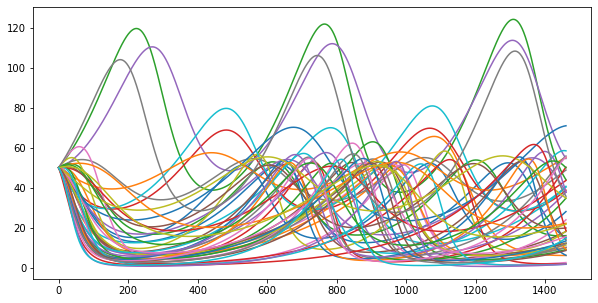

In [7]:
prey.plot(legend=None, figsize=(10,5))
plt.show()

### Look at final values of prey

In [8]:
preyfinal = pd.DataFrame(prey.iloc[-1])

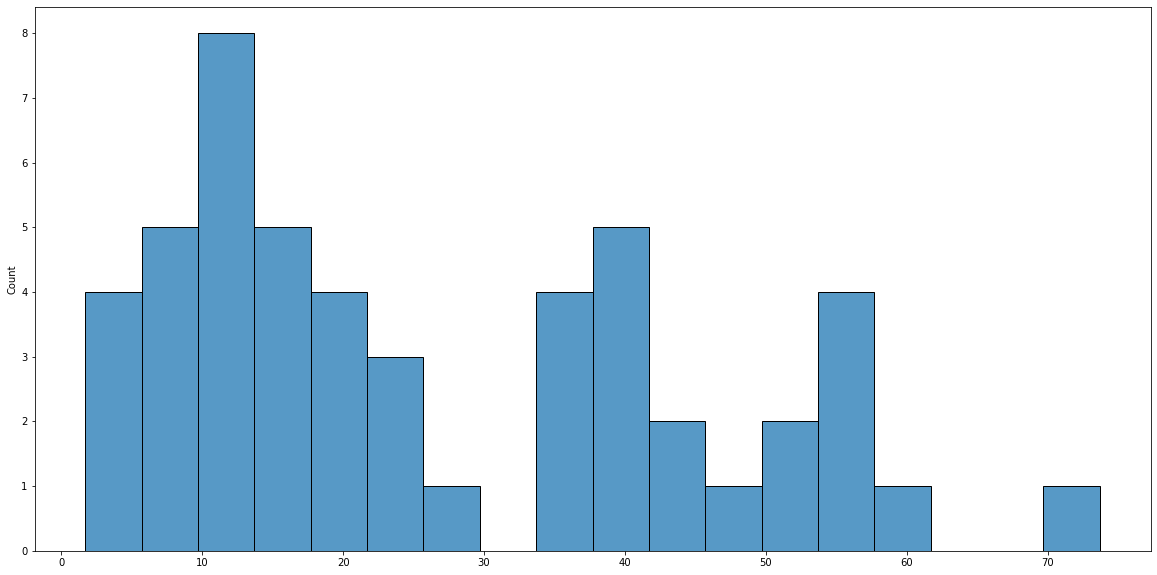

In [9]:
fig, ax = plt.subplots(figsize=(20,10))
sns.histplot(data=preyfinal, ax=ax, legend=None, binwidth=4)
plt.show()

In [10]:
X = experiments[["predation_rate", "predator_efficiency", "predator_loss_rate", "prey_birth_rate"]]
X = sm.add_constant(X)
Y = preyfinal

In [11]:
mod_fv = sm.OLS(Y, X).fit()

In [12]:
mod_fv.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   1460   R-squared:                       0.410
Model:                            OLS   Adj. R-squared:                  0.357
Method:                 Least Squares   F-statistic:                     7.807
Date:                Wed, 05 May 2021   Prob (F-statistic):           7.23e-05
Time:                        11:21:33   Log-Likelihood:                -202.84
No. Observations:                  50   AIC:                             415.7
Df Residuals:                      45   BIC:                             425.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -4.6931     15.134     -0.310      0.758     -35.175      25.789
predation_rate       6693.3479   3021.864      2.215      0.032     607.002    1.28e+04
predator_efficiency -1.056e+04   2529.757     -4.175      0.000   -1.57e+04   -5466.257
predator_loss_rate    643.8968    193.575      3.326      0.002     254.017    1033.777
prey_birth_rate       275.8467    383.917      0.719      0.476    -497.403    1049.096
==============================================================================
Omnibus:                        7.618   Durbin-Watson:                   2.128
Prob(Omnibus):                  0.022   Jarque-Bera (JB):                7.388
Skew:                           0.940   Prob(JB):                       0.0249
Kurtosis:                       3.104   Cond. No.                     1.52e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.52e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Mean values of Prey

In [13]:
Y = [i.mean() for i in outcomes["prey"]]

In [14]:
mod_mean = sm.OLS(Y, X).fit()

In [15]:
mod_mean.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.869
Model:                            OLS   Adj. R-squared:                  0.857
Method:                 Least Squares   F-statistic:                     74.33
Date:                Wed, 05 May 2021   Prob (F-statistic):           3.06e-19
Time:                        11:21:33   Log-Likelihood:                -155.14
No. Observations:                  50   AIC:                             320.3
Df Residuals:                      45   BIC:                             329.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  17.9014      5.829      3.071      0.004       6.161      29.641
predation_rate       -829.3049   1163.861     -0.713      0.480   -3173.442    1514.832
predator_efficiency -1.353e+04    974.328    -13.891      0.000   -1.55e+04   -1.16e+04
predator_loss_rate    589.5315     74.555      7.907      0.000     439.371     739.693
prey_birth_rate       348.4296    147.865      2.356      0.023      50.615     646.244
==============================================================================
Omnibus:                       16.750   Durbin-Watson:                   1.794
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               21.512
Skew:                           1.187   Prob(JB):                     2.13e-05
Kurtosis:                       5.166   Cond. No.                     1.52e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.52e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<h1 class="analysis">Analysis</h1>
<div class="analysis"> 
The coefficients show that <i>predator loss rate</i> has the most influence on the prey-variable. The P-value indicates that we can reject the null-hypothesis. Note that the margin of error for <i>predation rate</i> and <i>predator efficiency</i> is extremely high.
</div>

<AxesSubplot:xlabel='predation_rate'>

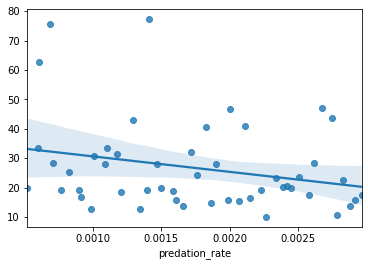

In [16]:
# U think he wants us to plot with statsmodels as well?
import seaborn as sns
sns.regplot(x=X["predation_rate"], y=Y)

## Standard deviations

In [20]:
Y = outcomes["prey"].std(axis=1)

In [21]:
mod_std = sm.OLS(Y, X).fit()

In [22]:
mod_std.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                 -0.065
Method:                 Least Squares   F-statistic:                    0.2577
Date:                Wed, 05 May 2021   Prob (F-statistic):              0.903
Time:                        11:22:14   Log-Likelihood:                -135.35
No. Observations:                  50   AIC:                             280.7
Df Residuals:                      45   BIC:                             290.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  14.9957      3.924      3.822      0.000       7.093      22.898
predation_rate        -81.6673    783.430     -0.104      0.917   -1659.576    1496.241
predator_efficiency  -481.0379    655.849     -0.733      0.467   -1801.986     839.910
predator_loss_rate      6.2834     50.185      0.125      0.901     -94.794     107.361
prey_birth_rate        46.2905     99.532      0.465      0.644    -154.177     246.758
==============================================================================
Omnibus:                       11.360   Durbin-Watson:                   2.367
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               23.435
Skew:                           0.480   Prob(JB):                     8.15e-06
Kurtosis:                       6.214   Cond. No.                     1.52e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.52e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Comparison of coefficients

In [64]:
params = pd.DataFrame(mod_fv.params, columns=["final"])
params["means"] = mod_mean.params
params["std"] = mod_std.params
params.drop(index="const", inplace=True)

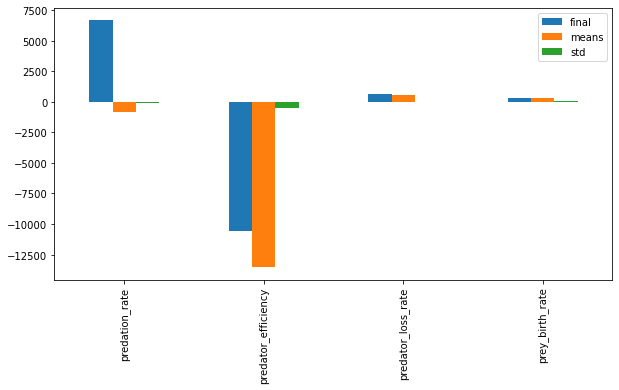

In [70]:
fig, ax = plt.subplots(figsize=(10,5))
params.plot.bar(ax=ax)
plt.show()

### Comparison of rsquared

In [68]:
print(mod_fv.rsquared_adj)
print(mod_mean.rsquared_adj)
print(mod_std.rsquared_adj)

0.3571974838629429
0.856859040415651
-0.06450608448084627


In [69]:
bse = pd.DataFrame(mod_fv.bse, columns=["final"])
bse["means"] = mod_mean.bse
bse["std"] = mod_std.bse
bse.drop(index="const", inplace=True)

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
params.plot.bar(ax=ax)
plt.show()

## Sobol

In [5]:
with MultiprocessingEvaluator(py_model, n_processes=processes) as evaluator:
    sa_experiments, sa_outcomes = perform_experiments(py_model, scenarios=50 * (2 * 4 + 2), uncertainty_sampling=SOBOL)

In [6]:
problem = get_SALib_problem(py_model.uncertainties)
Si = sobol.analyze(problem, sa_outcomes['prey'].ravel(), calc_second_order=True, print_to_console=False)

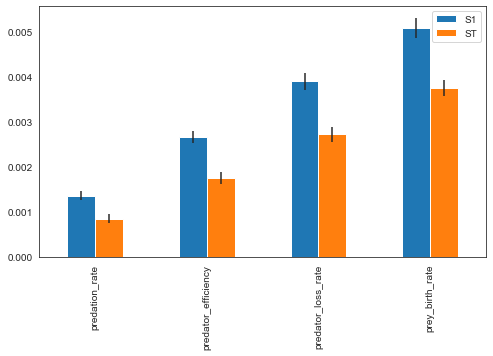

In [7]:
scores_filtered = {k:Si[k] for k in ['ST','ST_conf','S1','S1_conf']}
Si_df = pd.DataFrame(scores_filtered, index=problem['names'])

sns.set_style('white')
fig, ax = plt.subplots(1)

indices = Si_df[['S1','ST']]
err = Si_df[['S1_conf','ST_conf']]

indices.plot.bar(yerr=err.values.T,ax=ax)
fig.set_size_inches(8,6)
fig.subplots_adjust(bottom=0.3)
plt.show()

## Extra-trees analysis

In [26]:
sobol_mean = pd.Series([i.mean() for i in sa_outcomes["prey"]]).astype('int')

In [47]:
sobol_std = pd.Series(sa_outcomes["prey"].std(axis=1)).astype('int')

In [53]:
sobol_final = pd.DataFrame(sa_outcomes["prey"]).T.iloc[-1]

In [54]:
scores = []
for y in [sobol_mean, sobol_std, sobol_final]:
    scores.append(feature_scoring.get_ex_feature_scores(sa_experiments, y, mode=RuleInductionType.REGRESSION, nr_trees=100, max_features=0.6)[0])

In [63]:
scores

[                            1
 0                            
 predator_efficiency  0.777412
 predator_loss_rate   0.200179
 prey_birth_rate      0.012212
 predation_rate       0.010198,
                             1
 0                            
 predation_rate       0.392241
 predator_efficiency  0.326143
 prey_birth_rate      0.160979
 predator_loss_rate   0.120637,
                             1
 0                            
 predator_efficiency  0.506136
 predator_loss_rate   0.224918
 prey_birth_rate      0.202852
 predation_rate       0.066093]

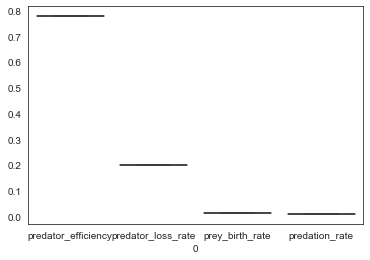

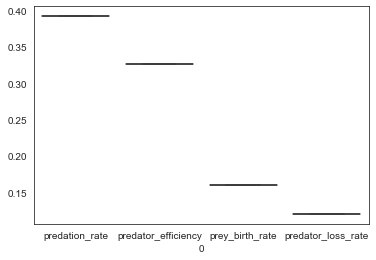

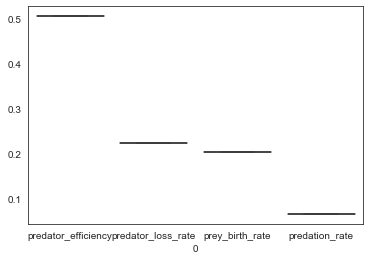

In [66]:
for i in scores:
    sns.boxplot(data=i.T)
    plt.show()

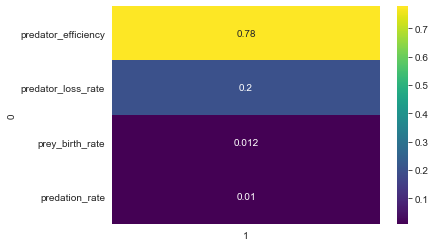

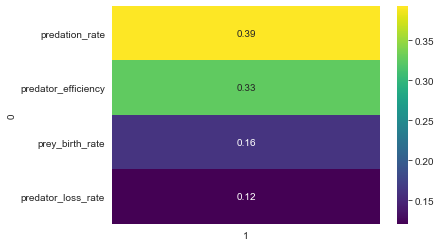

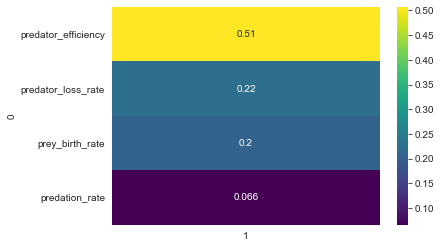

In [69]:
for i in scores:
    sns.heatmap(i, annot=True, cmap='viridis')
    plt.show()

In [76]:
scores

[                            1
 0                            
 predator_efficiency  0.777412
 predator_loss_rate   0.200179
 prey_birth_rate      0.012212
 predation_rate       0.010198,
                             1
 0                            
 predation_rate       0.392241
 predator_efficiency  0.326143
 prey_birth_rate      0.160979
 predator_loss_rate   0.120637,
                             1
 0                            
 predator_efficiency  0.506136
 predator_loss_rate   0.224918
 prey_birth_rate      0.202852
 predation_rate       0.066093]

array(['predator_efficiency', 'predator_loss_rate', 'prey_birth_rate',
       'predation_rate'], dtype=object)

In [106]:
scores_df = pd.concat(scores, axis=1, sort=False)

In [118]:
scores_list = scores_df.to_numpy()

In [128]:
scores_list

array([[0.77741156, 0.32614296, 0.50613638],
       [0.2001785 , 0.12063716, 0.22491803],
       [0.01221162, 0.16097904, 0.20285227],
       [0.01019833, 0.39224084, 0.06609333]])

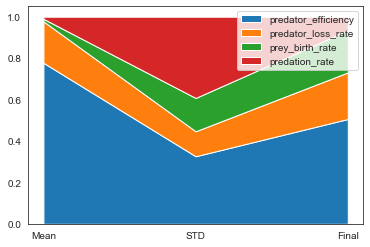

In [135]:
fig, ax = plt.subplots()
ax.stackplot(range(scores_list.shape[1]), scores_list, labels=scores[0].index.values)
plt.legend()
ax.set_xticks(range(3)) # <--- set the ticks first
ax.set_xticklabels(["Mean", "STD", "Final"])
plt.show()